In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
sns.set(font_scale=1.5)
sns.set_palette("Set2")

from experiments import Status

In [2]:
INTERESTING_COLUMNS = ["benchmark", "solver", "status", "wallclock time", "result"]

This is the shape of the data, and how to produce it from inputs:

In [3]:
from collections import namedtuple

SMTCompResult = namedtuple("SMTCompResult", ["track", "benchmark_set", "benchmark", "solver", "status", "runtime"])

def parse_file(filepath):
    file = filepath.strip()
    parts = file.split("/")
    assert parts[-1][-5:] == ".smt2", f"{parts[-1]} does not end with .smt2!"
    return file, parts[0], parts[1]

def parse_outcome(outcome):
    outcome = outcome.strip().lower()
    if outcome == "sat":
        return Status.SAT
    if outcome == "unsat":
        return Status.UNSAT
    if "command exited" in outcome:
        return Status.ERROR
    if "command terminated" in outcome:
        return Status.ERROR
    if "parse error" in outcome:
        return Status.ERROR
    if "out of memory" in outcome:
        return Status.MEMORY_OUT
    if "error" in outcome:
        return Status.ERROR
    if "--" in outcome:
        return Status.ERROR
    if "unknown" == outcome:
        return Status.ERROR
    if "starexec-unknown" == outcome:
        return Status.ERROR
    assert False, f"Unknown status: {outcome}"

During SMT-COMP, specifically OSTRICH and Z3-noodler got a re-run of some of the experiments, we splice in those results:

In [4]:
smt_comp = pd.read_csv("Job59410_info.zip")[INTERESTING_COLUMNS]
smt_comp_fixed = pd.read_csv("Job59668_info.zip")[INTERESTING_COLUMNS]
fixed_solvers = smt_comp_fixed[smt_comp_fixed["solver"].isin(["OSTRICH 1.3 SMT-COMP fixed", "Z3-Noodler"])]
smt_comp = smt_comp[~smt_comp.solver.isin(["OSTRICH 1.3 SMT-COMP", "Z3-Noodler"])]
smt_comp = pd.concat([smt_comp, fixed_solvers])
smt_comp['benchmark'] = smt_comp['benchmark'].str.replace("track_single_query/", "")

Apparently, there are benchmarks in the set that weren't part of SMT-COMP, so we just ignore those for an apples-to-applescomparison:

In [5]:
used_benchmarks = smt_comp.benchmark.unique()

Now, we load our own re-runs of SMT-COMP with Ostrich x CATRA, and splice those in too:

In [6]:
#catra_qf_snia = pd.read_csv("Job62395_info_QF_SNIA.zip")[INTERESTING_COLUMNS]
#catra_qf_s = pd.read_csv("Job62397_info_QF_S.zip")[INTERESTING_COLUMNS]
#catra_qf_slia = pd.read_csv("Job62396_info_QF_SLIA.zip")[INTERESTING_COLUMNS]

A bug in QF_S was discovered independently by us and the AEC during artefact evaluation. We addressed the bug and reran the relevant benchmarks on StarExec. These are the results:

In [9]:
catra_qf_s = pd.read_csv("Job62454_info_QF_S.zip")[INTERESTING_COLUMNS]
catra_qf_s.solver = catra_qf_s['solver'].str.replace("Ostrich CA-Str", "CA-Str")

In [10]:
catra_qf_slia = pd.read_csv("Job62455_info_QF_SLIA.zip")[INTERESTING_COLUMNS]
catra_qf_slia.solver = catra_qf_slia['solver'].str.replace("Ostrich CA-Str", "CA-Str")

In [11]:
catra_results = pd.concat([catra_qf_slia, catra_qf_s])
catra_results = catra_results[catra_results.benchmark.isin(used_benchmarks)]

In [12]:
smt_comp = pd.concat([smt_comp, catra_results])

And then we clean up the labelling slightly:

In [13]:
smt_comp['solver'] = smt_comp['solver'].str.replace("OSTRICH 1.3 SMT-COMP fixed", "Ostrich 1.3")
smt_comp['solver'] = smt_comp['solver'].str.replace("cvc5-default-2023-05-16-ea045f305", "cvc5")
smt_comp['solver'] = smt_comp['solver'].str.replace("Ostrich CA-Str", "CA-Str")

smt_comp = smt_comp.rename(columns={"wallclock time": "runtime"})
smt_comp['track'] = smt_comp.benchmark.apply(lambda x: parse_file(x)[1])
smt_comp = smt_comp[smt_comp['track'].isin(["QF_S", "QF_SLIA"])]

smt_comp['benchmark_set'] = smt_comp.benchmark.apply(lambda x: parse_file(x)[2])
smt_comp['status'] = smt_comp["result"].apply(parse_outcome)
smt_comp = smt_comp.drop(columns=["result"])

Now we set up categories for Pandas, and order outcomes (SAT etc) such that SAT wins over UNSAT, which wins over TIMEOUT, which, ... etc.

In [14]:
smt_comp['solver'] = smt_comp['solver'].astype("category")
smt_comp['status'] = smt_comp['status'].astype("category")
smt_comp['track'] = smt_comp['track'].astype("category")
smt_comp['benchmark'] = smt_comp['benchmark'].astype("category")
smt_comp['benchmark_set'] = smt_comp['benchmark_set'].astype("category")
smt_comp['status'] = smt_comp['status'].cat.set_categories([Status.SAT, Status.UNSAT, Status.TIMEOUT, Status.MEMORY_OUT, Status.ERROR], ordered=True)
#smt_comp = smt_comp.drop(["solver id", "benchmark id", "configuration id", "cpu time", "memory usage", "pair id", "configuration", "expected"], axis=1)
# This fills NaN columns using the first non-NaN value in the group, essentially populating expected outcomes etc.
#smt_comp.update(smt_comp.groupby(['benchmark'], observed=False)[['expected', 'configuration']].bfill())
#smt_comp.update(smt_comp.groupby(['benchmark'], observed=False)[['expected', 'configuration']].ffill())

For some reason, some results are missing for Z3-Noodler?!

In [15]:
smt_comp.groupby('solver', observed=False).size()

solver
CA-Str         30785
Ostrich 1.3    30785
Z3-Noodler     30785
cvc5           30785
z3alpha        30785
dtype: int64

In [16]:
len(smt_comp[smt_comp.track == "QF_SLIA"].benchmark.unique())

21938

## Soundness check
Here we group by benchmark and status to see if there are diverging opinions about satisfiability.

In [17]:
success_runs = smt_comp[smt_comp['status'] < Status.TIMEOUT]
success_runs_by_instance = success_runs.groupby(['benchmark'], observed=False)

nr_statuses = success_runs_by_instance.status.nunique().reset_index()
contested = nr_statuses[nr_statuses['status'] > 1]
contested

,benchmark,status
19887,QF_SLIA/2019-Jiang/slent/slent_stranger_str_re...,2


In [18]:
smt_comp[(smt_comp.benchmark.isin(contested.benchmark)) & (smt_comp.status < Status.TIMEOUT)]\
    .set_index(["benchmark", "solver"])\
    .drop(["track", "runtime", "benchmark_set"], axis=1) \
    .sort_values("benchmark")

status
benchmark                                          solver                  
QF_SLIA/2019-Jiang/slent/slent_stranger_str_rep... cvc5          Status.SAT
                                                   z3alpha       Status.SAT
                                                   Z3-Noodler  Status.UNSAT

We manually change the result to an error (and leave an assertion to poke us if it changes):

In [20]:
contested_names = set(["QF_SLIA/2019-Jiang/slent/slent_stranger_str_rep_19543_sink.smt2"
                       #, "QF_S/20230329-automatark-lu/instance08425.smt2"
                      ])
assert set(contested.benchmark) == set(contested_names)

smt_comp.loc[(smt_comp.solver=="Z3-Noodler") \
               & (smt_comp.benchmark=="QF_SLIA/2019-Jiang/slent/slent_stranger_str_rep_19543_sink.smt2"), \
               "status"] = Status.ERROR

#smt_comp.loc[(smt_comp.solver=="Ostrich CA-Str") \
#               & (smt_comp.benchmark=="QF_S/20230329-automatark-lu/instance08425.smt2"), \
#               "status"] = Status.ERROR

## Making virtual portfolio solvers
Create a new solver which is the best output of ostrich and ostrich-catra:

In [21]:
portfolio_catra = smt_comp[smt_comp.solver.isin(["CA-Str", "Ostrich 1.3"])]\
    .sort_values(['status', 'runtime'])\
    .groupby("benchmark", observed=False)\
    .first()\
    .reset_index()\
    .assign(solver="Ostrich+CA")

We also create a portfolio for *every solver that isn't Ostrich*:

In [22]:
portfolio_all = smt_comp[~smt_comp.solver.isin(["CA-Str", "Ostrich 1.3"])]\
    .sort_values(['status', 'runtime'])\
    .groupby("benchmark", observed=False)\
    .first()\
    .reset_index()\
    .assign(solver="Competitors")

In [23]:
smt_comp = pd.concat([smt_comp, portfolio_catra, portfolio_all])

Sanity-check: do we have the same number of results?

In [24]:
smt_comp.groupby('solver').size()

solver
CA-Str         30785
Competitors    30785
Ostrich 1.3    30785
Ostrich+CA     30785
Z3-Noodler     30785
cvc5           30785
z3alpha        30785
dtype: int64

In [25]:
smt_comp[smt_comp['status'] > Status.TIMEOUT]

,benchmark,solver,status,runtime,track,benchmark_set
271177,QF_S/2019-Jiang/slog/slog_stranger_1820_sink.smt2,z3alpha,Status.ERROR,1200.110000,QF_S,2019-Jiang
274040,QF_S/20230329-automatark-lu/instance14134.smt2,cvc5,Status.ERROR,1200.120000,QF_S,20230329-automatark-lu
274213,QF_S/20230329-automatark-lu/instance12439.smt2,z3alpha,Status.ERROR,1200.030000,QF_S,20230329-automatark-lu
275109,QF_S/20230329-automatark-lu/instance14003.smt2,z3alpha,Status.ERROR,33.236100,QF_S,20230329-automatark-lu
275120,QF_S/20230329-automatark-lu/instance08782.smt2,cvc5,Status.ERROR,1200.030000,QF_S,20230329-automatark-lu
...,...,...,...,...,...,...
30646,QF_SLIA/20230403-webapp/str-rep-all/str_replac...,Competitors,Status.ERROR,0.036893,QF_SLIA,20230403-webapp
30647,QF_SLIA/20230403-webapp/str-rep-all/str_replac...,Competitors,Status.ERROR,0.036137,QF_SLIA,20230403-webapp
30654,QF_SLIA/20230403-webapp/str-rep-all/str_replac...,Competitors,Status.ERROR,0.038940,QF_SLIA,20230403-webapp
30658,QF_SLIA/20230403-webapp/str-rep-all/str_replac...,Competitors,Status.ERROR,0.037101,QF_SLIA,20230403-webapp


In [26]:
def plot_results(df, title="Outcome by solver"):
    fig, ax = plt.subplots()
    runtime_by_status = df.groupby(['solver', 'status'], observed=False).size().reset_index()
    runtime_by_status = runtime_by_status[runtime_by_status[0] > 0]
    runtime_by_status.rename(columns = {0: 'count'}, inplace = True)
    runtime_by_status = runtime_by_status.set_index(['solver', 'status'])
    plot = runtime_by_status.unstack().plot.bar(figsize=(10,6), 
                                     stacked=True, 
                                     ylabel="nr instances",
                                     title=title, 
                                     ax=ax)


    nr_solvers = df.solver.nunique()
    bars = plot.patches
    hatches = [ *(["*"] * nr_solvers), *(["."] * nr_solvers), *(["/"] * nr_solvers), *(["x"] * nr_solvers)]


    for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch)

    ax.legend([str(heading).replace("Status.", "") for _, heading in runtime_by_status.unstack().columns])


#plt.tight_layout()
#plt.savefig(f'{commit}-by-solver.pdf', dpi=300)

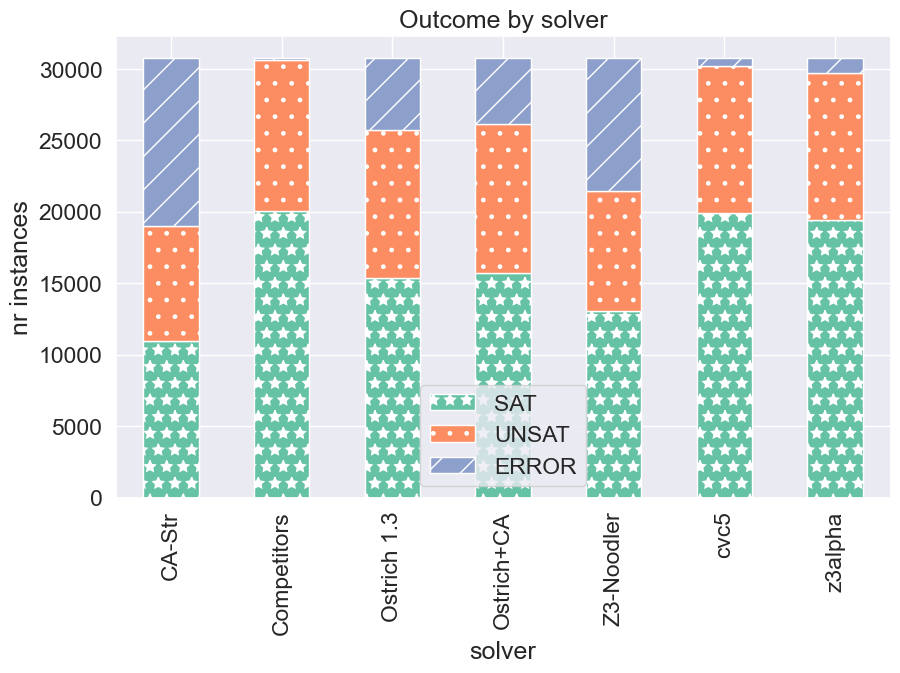

In [27]:
plot_results(smt_comp)

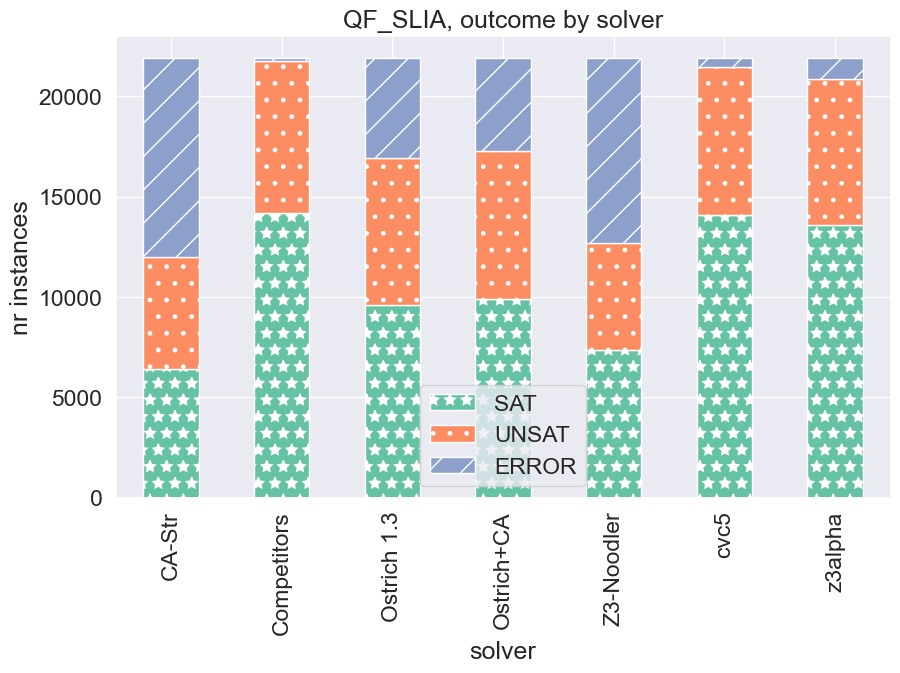

In [28]:
plot_results(smt_comp[(smt_comp.track == "QF_SLIA")], "QF_SLIA, outcome by solver")

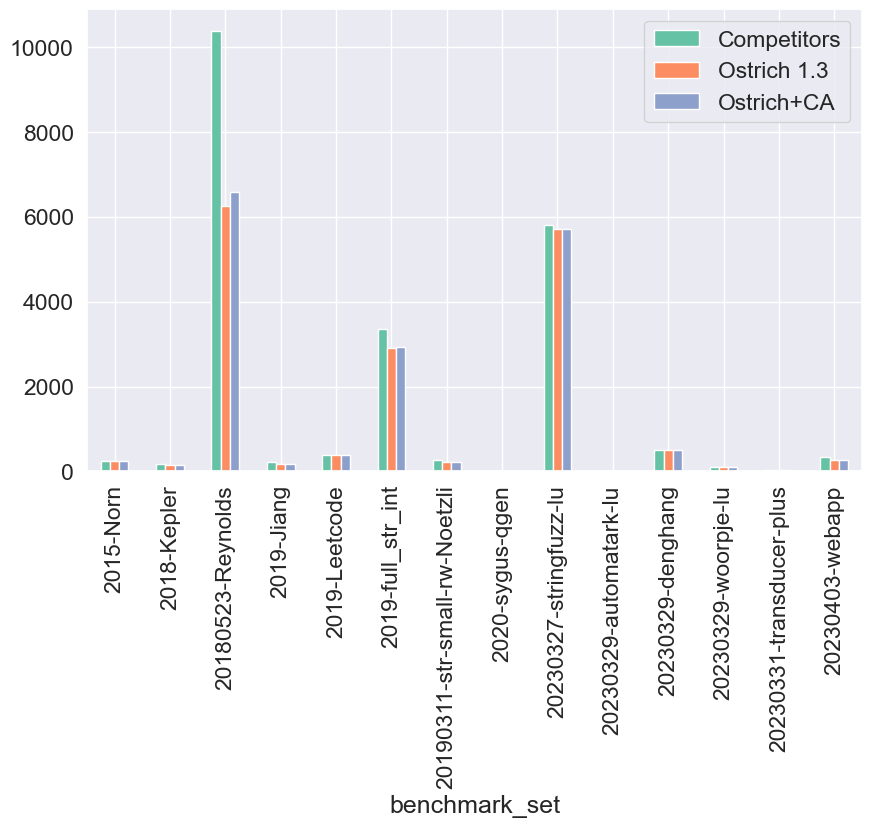

In [29]:
fig, ax = plt.subplots()


smt_comp[(smt_comp.track == 'QF_SLIA') & (smt_comp.solver.isin(["Ostrich 1.3", "Ostrich+CA", "Competitors"])) & (smt_comp.status < Status.TIMEOUT)]\
    .groupby(["benchmark_set", "solver"], observed=False)\
    .size()\
    .reset_index()\
    .rename(columns = {0: 'solved'})\
    .set_index(["benchmark_set", "solver"])\
    .unstack()\
    .plot\
    .bar(ax=ax, figsize=(10,6))

_, labels = ax.get_legend_handles_labels()

ax.legend(list(map(lambda x: x.replace("solved, ", "").replace("(", "").replace(")", ""), labels)))

In [30]:
by_sat_status = pd.DataFrame(smt_comp.groupby('benchmark', observed=True).status.min())
by_sat_status['kind'] = by_sat_status['status'].astype("category")
by_sat_status['kind'] = by_sat_status.kind.cat.set_categories([Status.SAT, Status.UNSAT])
del(by_sat_status['status'])

known_solved_with_kind = smt_comp[smt_comp['status'] < Status.TIMEOUT]\
    .join(by_sat_status, on='benchmark')

tbl = pd.pivot_table(known_solved_with_kind[known_solved_with_kind.track == "QF_SLIA"], values=['runtime'],
                     observed=False,
               index=['kind'], columns=['solver'],
               aggfunc='count')['runtime']
tbl.index = tbl.index.to_series().map(lambda x: str(x).replace("Status.", ""))
tbl.style.to_latex("qf_slia_comparison.tex", hrules=True)
tbl

solver,CA-Str,Competitors,Ostrich 1.3,Ostrich+CA,Z3-Noodler,cvc5,z3alpha
kind,,,,,,,
SAT,6411,14207,9586,9913,7344,14069,13599
UNSAT,5566,7574,7356,7389,5367,7377,7298


In [31]:
by_sat_status = pd.DataFrame(smt_comp.groupby('benchmark', observed=True).status.min())
by_sat_status['kind'] = by_sat_status['status'].astype("category")
by_sat_status['kind'] = by_sat_status.kind.cat.set_categories([Status.SAT, Status.UNSAT])
del(by_sat_status['status'])

known_solved_with_kind = smt_comp[smt_comp['status'] < Status.TIMEOUT]\
    .join(by_sat_status, on='benchmark')

tbl = pd.pivot_table(known_solved_with_kind[known_solved_with_kind.track == "QF_S"], values=['runtime'],
                     observed=False,
               index=['kind'], columns=['solver'],
               aggfunc='count')['runtime']
tbl.index = tbl.index.to_series().map(lambda x: str(x).replace("Status.", ""))
#tbl.style.to_latex("qf_slia_comparison.tex", hrules=True)
tbl

solver,CA-Str,Competitors,Ostrich 1.3,Ostrich+CA,Z3-Noodler,cvc5,z3alpha
kind,,,,,,,
SAT,4547,5848,5814,5818,5740,5835,5838
UNSAT,2477,2990,2986,2988,2970,2940,2959


## Per-track results

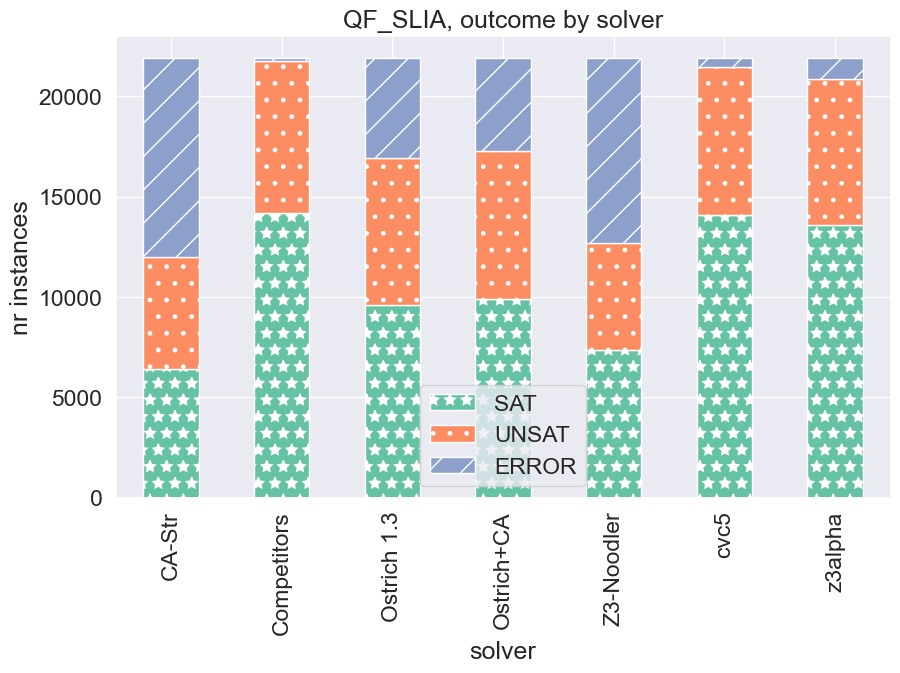

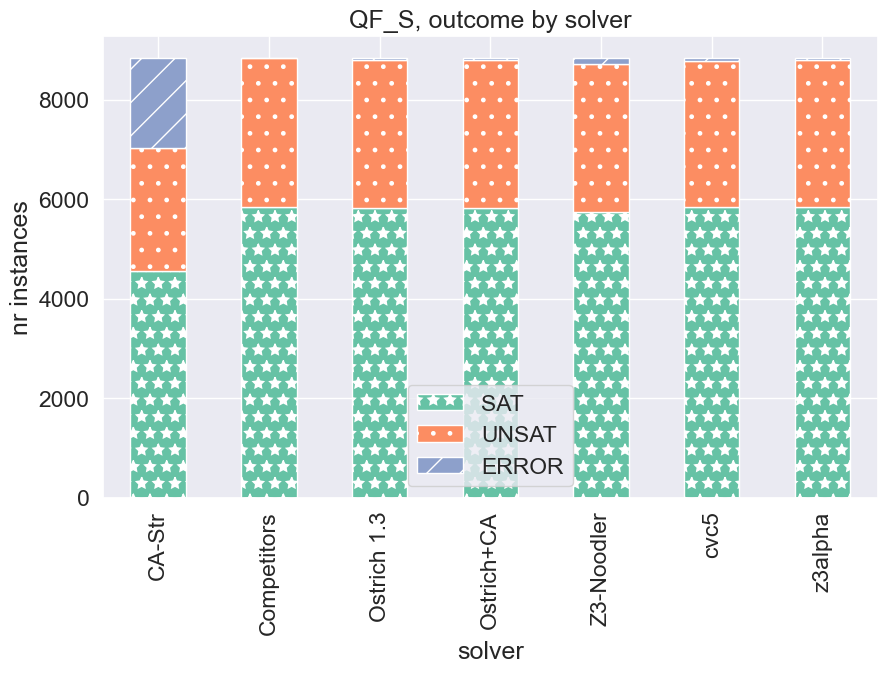

In [32]:
for track in ["QF_SLIA", "QF_S"]:
    plot_results(smt_comp[(smt_comp.track == track)], f"{track}, outcome by solver")

## Cactus plot

In [33]:
def solved_after(seconds, known_solved):
    df = known_solved[known_solved['runtime'] < seconds]\
        .groupby('solver', observed=False)\
        .size()\
        .reset_index()
    df['after (s)'] = seconds
    df = df.rename(columns = {0: 'nr solved'})
    return df

def prepare_cactus_plot(runtimes, timeout_s, step_size):
    return pd.concat([solved_after(i * step_size, runtimes) for i in range(int(timeout_s / step_size) + 1)], axis=0)

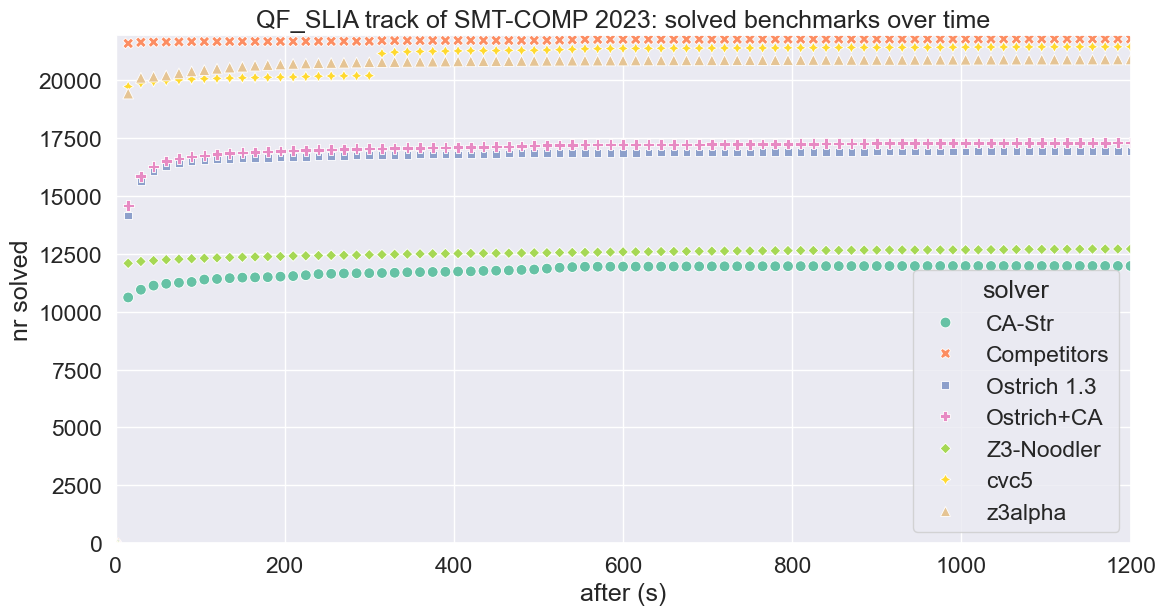

In [42]:
track = "QF_SLIA"
cactus_runtimes = smt_comp[(smt_comp.status < Status.TIMEOUT) & (smt_comp.track == track)][["solver", "runtime"]]
cactus_runtimes['solver'] = cactus_runtimes['solver'].astype("category")
cactus_data = prepare_cactus_plot(cactus_runtimes, timeout_s=1200, step_size=15)
fig, ax = plt.subplots(figsize=(12,6.5))

p = sns.scatterplot(data=cactus_data,
                    x='after (s)', 
                    y='nr solved', 
                    hue='solver', 
                    style='solver',
                    s=60,
                    ax=ax)
#ax.set(xscale="log", yscale="log")
ax.set_xlim(0, 1200)
ax.set_ylim(0, smt_comp[smt_comp.track == track].benchmark.unique().size)
ax.set_title(f"{track} track of SMT-COMP 2023: solved benchmarks over time")
plt.tight_layout()
plt.savefig('smt-comp-cactus.pdf', dpi=300)